#I. Import Necessary Libraries

In [1]:
#import necessary libraries
import os
import torch
import numpy as np
from torchvision import datasets, transforms, models
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import Counter
import random
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#retrieve the data
#train and test data directory
train_dir = "./drive/MyDrive/SkinDisease/train"
test_dir = "./drive/MyDrive/SkinDisease/test"

IMAGE_SIZE = 224
BATCH_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

#II. Examine Data Set

In [3]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2,  pin_memory=True)

class_names = train_dataset.classes
print(f"✅ Loaded {len(train_dataset)} training and {len(test_dataset)} test images")
print(f"📚 Number of classes: {len(class_names)} → {class_names}")

✅ Loaded 13898 training and 1546 test images
📚 Number of classes: 22 → ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']


1. Check images

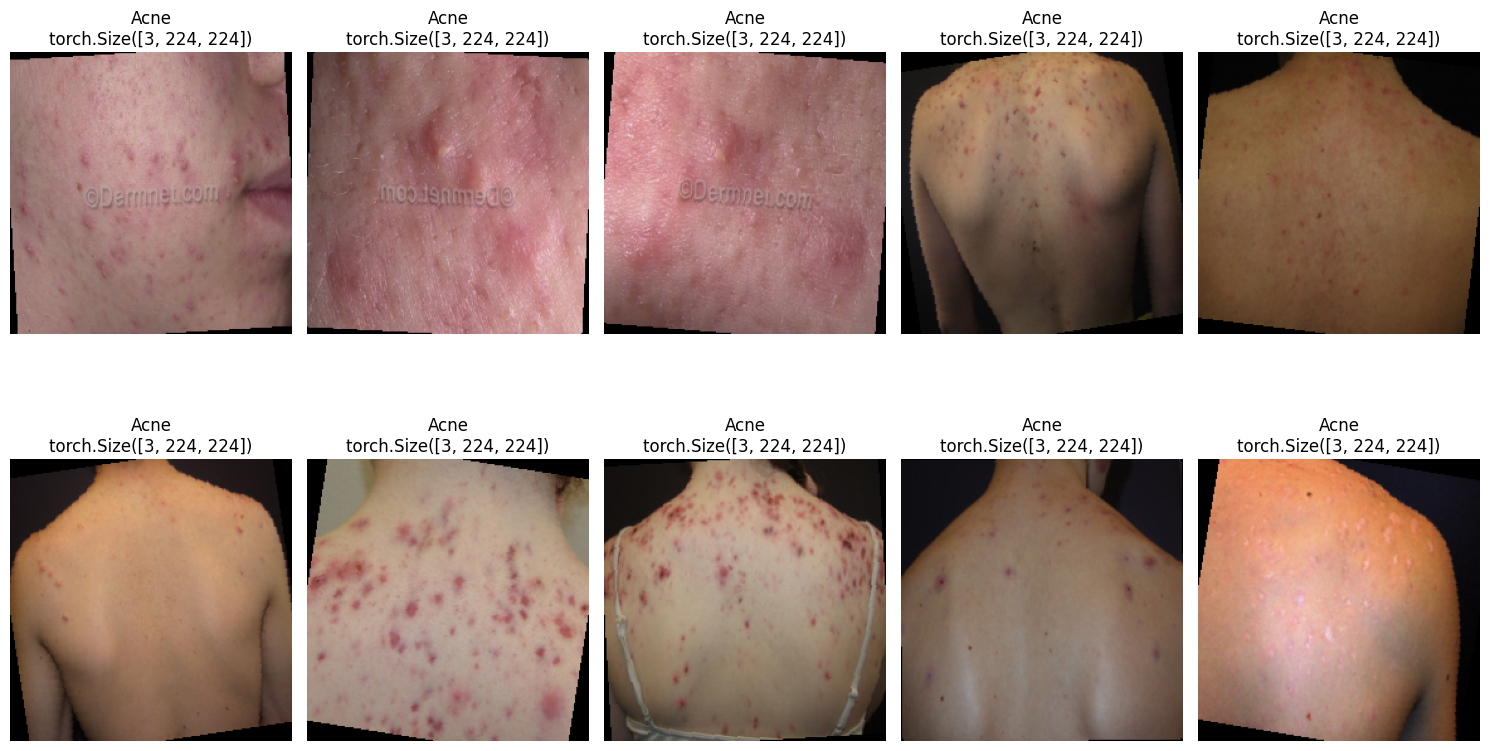

In [4]:
#view some example images
n = 5

fig, axes = plt.subplots(2, n, figsize=(15, 9))
for j in range(2):
  for i in range(n):
      image, label = train_dataset[i + (j*n)]
      img_display = image.permute(1, 2, 0).numpy() * 0.5 + 0.5
      axes[j][i].imshow(img_display)
      axes[j][i].set_title(f"{class_names[label]}\n{image.shape}")
      axes[j][i].axis("off")
plt.tight_layout()
plt.show()

In [5]:
# we see images in the same category can vay by severity and location

#III. Exploritory Data Analysis

1. Class distributions

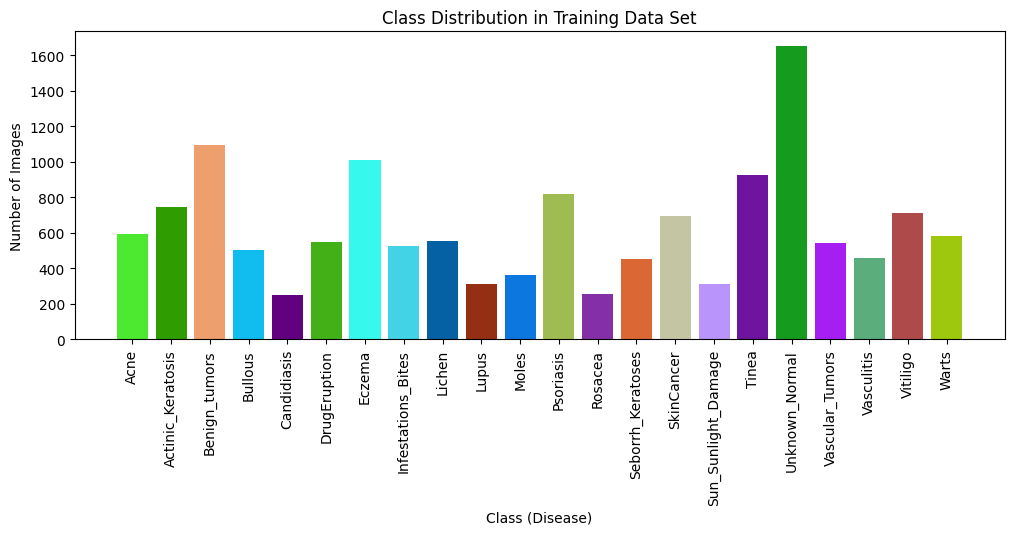

In [6]:
label_counts = Counter(train_dataset.targets)
plt.figure(figsize=(12, 4))

colors = [(random.random(), random.random(), random.random()) for _ in range(len(label_counts))]

plt.bar(class_names, label_counts.values(), color=colors)
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Data Set")
plt.ylabel("Number of Images")
plt.xlabel("Class (Disease)")

plt.show()

In [7]:
# we see a high amount of unkown_normal, benign_tumors, and Eczema,
# while there is a lot less Candidiasis and rosacea

2. Examine Weighted Loss

In [4]:
labels = train_dataset.targets
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=np.array(labels))
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"Class weights tensor: {class_weights}")

Class weights tensor: tensor([1.0653, 0.8446, 0.5780, 1.2534, 2.5473, 1.1549, 0.6255, 1.2056, 1.1424,
        2.0313, 1.7499, 0.7704, 2.4871, 1.3884, 0.9116, 2.0248, 0.6844, 0.3826,
        1.1634, 1.3703, 0.8848, 1.0892], device='cuda:0')


#IV. Train Models

In [5]:
num_classes = 22

## 1. EfficientNetV2

1. Load Model

In [6]:
effNet_Model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

2. Set loss and Optimizer

In [7]:
effNet_Model.classifier[1] = torch.nn.Linear(effNet_Model.classifier[1].in_features, num_classes)
effNet_Model = effNet_Model.to(device, memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(effNet_Model.parameters(), lr=.0001)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [8]:
scaler = torch.amp.GradScaler('cuda')
effNet_Model = torch.compile(model=effNet_Model, mode="reduce-overhead")

3. Train

In [9]:
num_epochs = 10
for epoch in range(num_epochs):
    effNet_Model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type="cuda"):
          outputs = effNet_Model(inputs)

          loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 2.4766
Epoch 2, Loss: 1.7132
Epoch 3, Loss: 1.3476
Epoch 4, Loss: 1.0931
Epoch 5, Loss: 0.8946
Epoch 6, Loss: 0.7417
Epoch 7, Loss: 0.6159
Epoch 8, Loss: 0.5051
Epoch 9, Loss: 0.4112
Epoch 10, Loss: 0.3453


4. Test

In [ ]:
effNet_Model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.amp.autocast(device_type="cuda"):
          outputs = effNet_Model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

5. Analyze

In [ ]:
#Confusion Mattrix
cm = confusion_matrix(all_labels, all_preds)
labels = test_dataset.classes

plt.figure(figsize=(14, 12))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot()

plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Per-class ROC
y_probs = np.vstack(all_preds)  # shape: (num_samples, num_classes)
y_true = np.array(all_labels)


# Binarize labels
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
n_classes = y_true_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(16, 12))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Per-Class ROC Curves')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



## 2. EfficientNet_v2_s

1. Load Model

In [ ]:
effNet2_Model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights)

2. Set loss and optimizer

In [ ]:
num_classes = 22 # Example: your dataset has 10 classes
effNet2_Model.classifier[1] = torch.nn.Linear(effNet2_Model.classifier[1].in_features, num_classes)
effNet2_Model = effNet2_Model.to(device, memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(effNet2_Model.parameters(), lr=.0001)

torch.backends.cudnn.benchmark = True

3. Train

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    effNet2_Model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type="cuda"):
          outputs = effNet2_Model(inputs)

          loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

4. Test

In [ ]:
effNet2_Model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = effNet2_Model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

## 3. ResNet18

## 4. MobileNet V3

# V. Compare Results

# Save Model for external use